### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [ ]:
data.shape

(4998, 141)

In [ ]:
features = data.iloc[:,:-1]
target = data.iloc[:, -1:]
print(features.shape)
print(target.shape)

(4998, 140)
(4998, 1)


### 2. Split the data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3998, 140)
(3998, 1)
(1000, 140)
(1000, 1)


In [ ]:
# use case is novelty detection so use only the normal data for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

#normalisation
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

### Autoencoder

In [ ]:
x_train_scaled.shape

(3998, 140)

In [ ]:
import tensorflow as tf
input_dim = tf.keras.Input(shape=(x_train_scaled.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(input_dim)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
encoder = tf.keras.layers.Dense(8, activation='relu')(x)   ##bottle-neck = 8 units

x = tf.keras.layers.Dense(64, activation='relu')(encoder)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
decoder = tf.keras.layers.Dense(x_train_scaled.shape[1], activation='sigmoid')(x)

autoencoder = tf.keras.Model(input_dim, decoder)
autoencoder.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = autoencoder.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=10,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/10
8/8 [==============================] - 1s 46ms/step - loss: 0.0119 - mse: 0.0288 - val_loss: 0.0117 - val_mse: 0.0284
Epoch 2/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0116 - mse: 0.0282 - val_loss: 0.0113 - val_mse: 0.0276
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 0.0111 - mse: 0.0269 - val_loss: 0.0104 - val_mse: 0.0253
Epoch 4/10
8/8 [==============================] - 0s 12ms/step - loss: 0.0101 - mse: 0.0244 - val_loss: 0.0092 - val_mse: 0.0221
Epoch 5/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0090 - mse: 0.0217 - val_loss: 0.0081 - val_mse: 0.0195
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0080 - mse: 0.0192 - val_loss: 0.0070 - val_mse: 0.0168
Epoch 7/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0071 - mse: 0.0169 - val_loss: 0.0061 - val_mse: 0.0145
Epoch 8/10
8/8 [==============================] - 0s 13ms/step - loss: 0.0063 - mse: 0.0151 - val

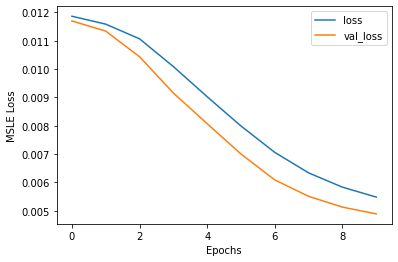

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
def find_threshold(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
    mean = np.mean(reconstruction_errors)
    std = np.mean(reconstruction_errors)
    return mean + std

def get_predictions(model, x_test_scaled, threshold):
    prediction = model.predict(x_test_scaled)
    errors = tf.keras.losses.msle(prediction, x_test_scaled)
    anomaly_mask = pd.Series(errors)>threshold
    #1-anomaly 0-normal
    preds = anomaly_mask.map(lambda x: 1.0 if x==True else 0.0)   #if error>threshold then 1, error< threshold then 0
    return preds

threshold = find_threshold(autoencoder, x_train_scaled)
print(f"Threshold: {threshold}")

predictions = get_predictions(autoencoder, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

Threshold: 0.009909426142921559


0.409